# **Setup**
 
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, import the libraries needed to complete the code Professor Melnikov presented in the video. 

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import pandas as pd, numpy as np, nltk, seaborn as sns, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

<hr style="border-top: 2px solid #606366; background: transparent;">

# **Review**

In this notebook, you'll practice finding important words and unimportant stopwords in a specific corpus. As you practice these tasks, recall that whether or not a word is important depends both on the specifc corpus you're working with and on the questions you want to answer. 

## **Create the TF-IDF Matrix**
<span style="color:black">Load the 15 quotes relating to language that you worked with in the previous actvity and build a TF-IDF vectorizer object. Note that this time when you build the TF-IDF matrix you will not filter out stopwords using the `nltk`'s list of common stopwords. 

In [2]:
LsQuotes = [
    "Learn a new language and get a new soul.",                   # Czech Proverb
    "A mistake is to commit a misunderstanding.",                 # Bob Dylan
    "Knowledge of languages is the doorway to wisdom.",           # Roger Bacon
    "Change your language and you change your thoughts.",         # Karl Albrecht
    "A different language is a different vision of life.",        # Federico Fellini
    "To have another language is to possess a second soul.",      # Charlemagne
    "Language is to the mind more than light is to the eye.",     # William Gibson
    "The limits of my language mean the limits of my world.",     # Ludwig Wittgenstein
    "He who knows no foreign languages knows nothing of his own.",# Johann Wolfgang von Goethe
    "Learning is a treasure that will follow its owner everywhere.",  # Chinese Proverb
    "You can never understand one language until you understand at least two.",  # Geoffrey Willans
    "Language is the blood of the soul into which thoughts run and out of which they grow.",  # Oliver Wendell Holmes
    "A special kind of beauty exists which is born in language, of language, and for language.",  # Gaston Bachelard
    "One should not aim at being possible to understand but at being impossible to misunderstand.",  # Marcus Fabius Quintilian
    "One language sets you in a corridor for life. Two languages open every door along the way."  # Frank Smith
]

tv = TfidfVectorizer(stop_words=None, lowercase=True)   # direct approach of building TF-IDF weights
tv

TfidfVectorizer()

## `fit_transform()`

<span style="color:black">Use the object's [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform) method, which fits and transforms the documents:

1. In [fitting](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit), the object learns the new vocabulary and inverse document frequency (IDF).
1. In [transforming](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform), the object uses learned vocabulary and IDF to transform documents.

The method returns a document–term matrix (DTM) with TF–IDF weights (not counts) in SciPy's sparse matrix format.

In [3]:
smTFIDF = tv.fit_transform(LsQuotes)     # create document-term matrix (DTM) in sparse format
smTFIDF

<15x90 sparse matrix of type '<class 'numpy.float64'>'
	with 138 stored elements in Compressed Sparse Row format>

Since the vocabulary includes stopwords, there are 90 words, which is rather large. It can be more effective to print its TF–IDF DTM in its transposed form (i.e., as a term–document or TDM), especially if you want to fit it within the screen.

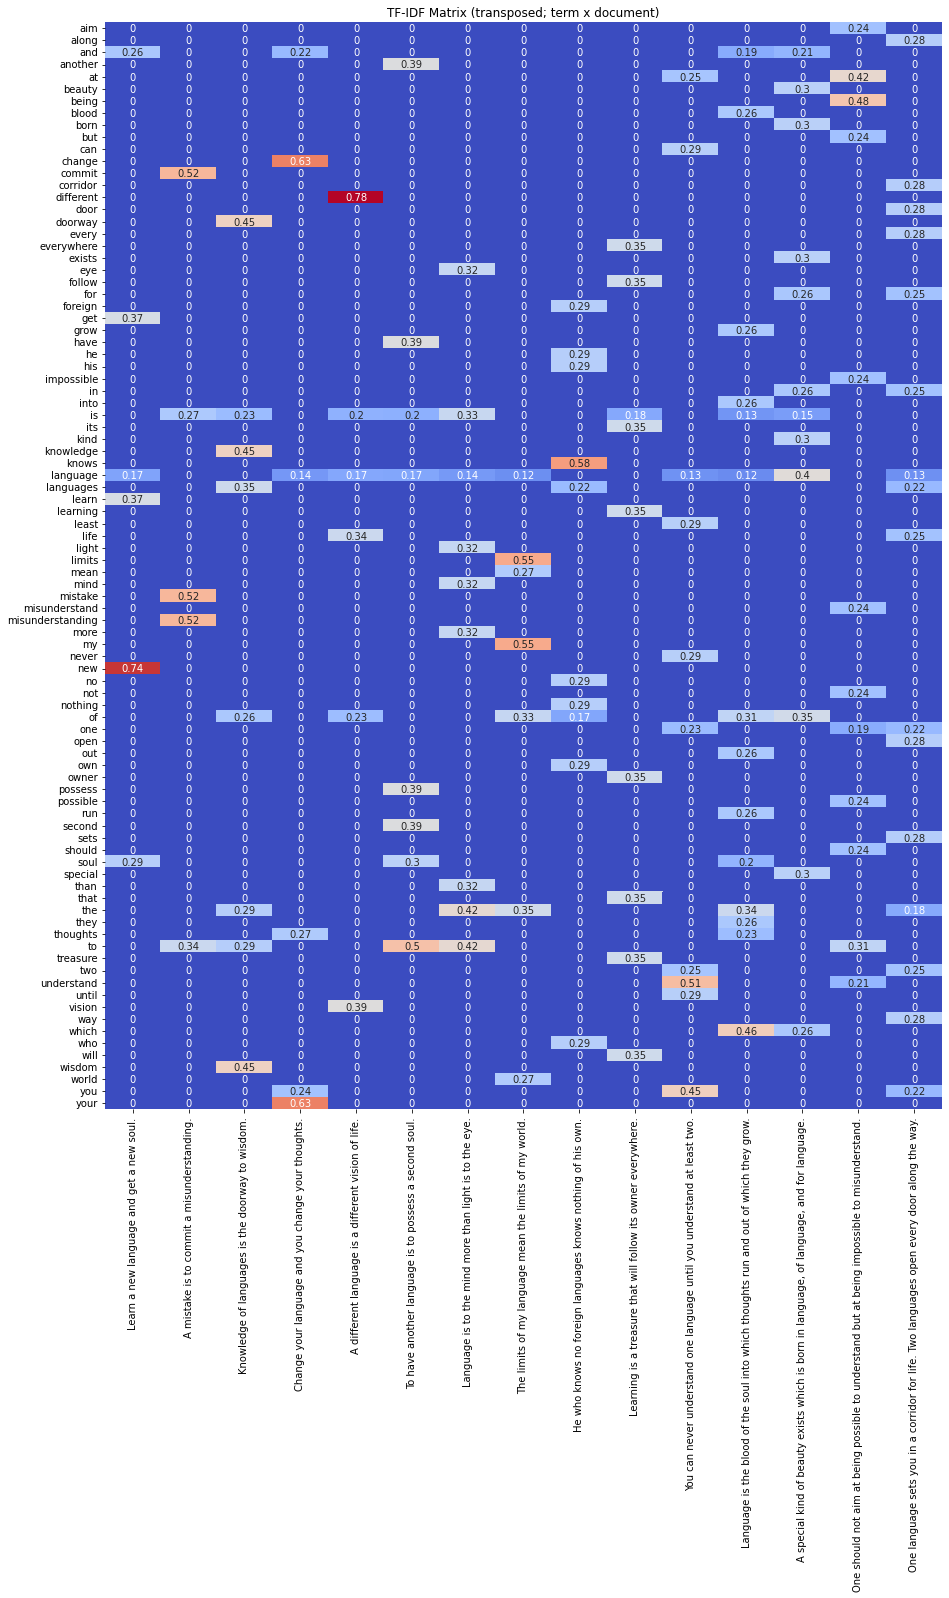

In [4]:
LsVocab = tv.get_feature_names()           # create a vocabulary of unique words in our corpus
dfTFIDF = pd.DataFrame(smTFIDF.toarray(), index=LsQuotes, columns=LsVocab)

def PlotDTM(df, LnSize=[30,5], sTitle='TF-IDF Matrix', nRotation=0):
    plt.rcParams['figure.figsize'] = LnSize   # plot wider figures
    ax = sns.heatmap(df, annot=True, cmap='coolwarm', cbar=False, annot_kws={'rotation': nRotation});
    _ = ax.set_title(sTitle);

PlotDTM(dfTFIDF.T, LnSize=[15,20], sTitle='TF-IDF Matrix (transposed; term x document)')

Review the matrix above carefully and note the following:

1. The weights vary between 0 and 1 with highest indicating greater importance of words. 
1. Words appearing in multiple quotes have multiple weights.
1. Most words appear to have weights between .2 and .3.
1. "language" is still the most common word and has low weights, reaching 0.12 in the second quote.
    1. Some other notable stopwords are "is," "of," "the," etc. These appear in many quotes and, hence, have low weights.
1. While the words "new" and "different" appear most important, they only occur in one document. This does not help compare similarity among documents. In fact, we might consider dropping words with only one occurrence for that reason.

## Assessing the "Importance" of Words in the TF-IDF Matrix

There are many ways to define and compute the "importance" of words in a TF-IDF matrix. One way you might define importance is to consider words important if they have high weights in the matrix for at least one quote (i.e., words that do not contribute any high weights are of low importance). You can then order the words by the `max()` method and evaluate whether you agree with this definition of importance. 

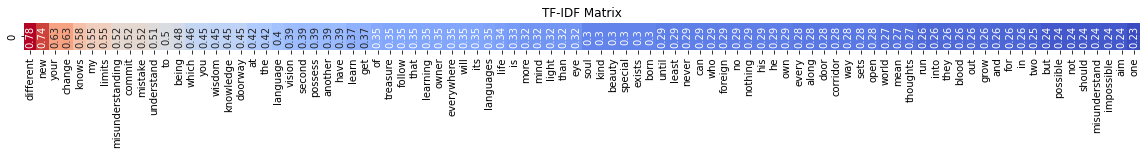

In [5]:
SWordImportance = dfTFIDF.max(axis=0).sort_values(ascending=False).to_frame()
PlotDTM(SWordImportance.T, LnSize=[20, 0.5], nRotation=90)

Here, the top words in red would probably be considered important. However, this might not be the best method because we would expect "language" and other low-importance words to be towards the bottom of this list. However, "language" with a coefficient of 0.4 is actually closer to the top of the list, which is likely unexpected.

##  Using Thresholds to Assess Importance

You can threshold the matrix by applying a condition on the maximum weight of each word. The choice of this threshold is an art and depends on business needs and domain expertise. For now, you will set it to 0.5.

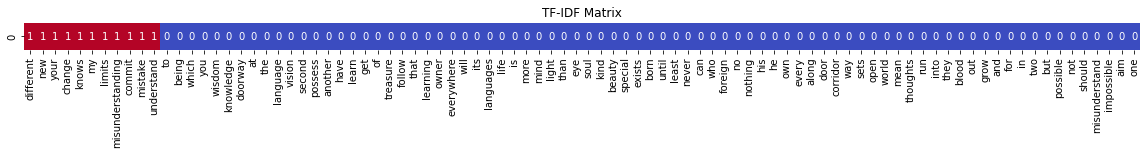

In [6]:
dfImportant = SWordImportance>0.5    # mask of important words
PlotDTM(dfImportant.T, LnSize=[20, 0.5])

<span style="color:black"> This threshold returns 11 words out of 90 or words above 77th percentile. All of the most important words are now highlighted in red.

You can retrieve the words themselves, if needed, using the `index` attribute.

In [7]:
dfImportant[dfImportant.values].index

Index(['different', 'new', 'your', 'change', 'knows', 'my', 'limits',
       'misunderstanding', 'commit', 'mistake', 'understand'],
      dtype='object')

Another way to define word importance is to take a mean of each word's weight across the quotes in which it appears and ignore any words that are always zero. For that reason, you convert all zeros to `np.NaN` values and then call the `mean()`  method, which only considers floating point values.

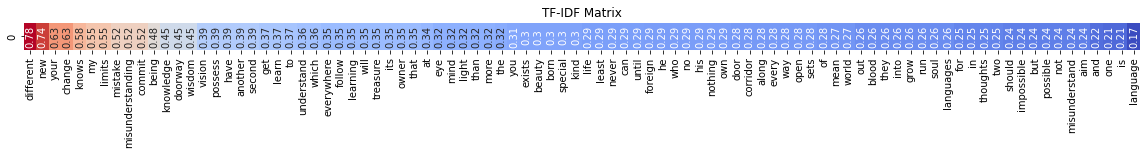

In [8]:
dfAvgWeights = dfTFIDF.replace(0, np.NaN).mean(axis=0).sort_values(ascending=False).to_frame()
PlotDTM(dfAvgWeights.T, LnSize=[20, 0.5], nRotation=90)

<span style="color:black">This metric appears more appropriate, since "language" and other common words drop to the bottom of the list, as we would likely expect in this context - words that are "common" and do not help in differentiating our documents are expected to have relatively low weights.

As before, you can set a threshold on this new metric and consider words below 0.25 as stopwords. In fact, some of these words are in the list of common stopwords defined in NLTK.

pandas.core.frame.DataFrame

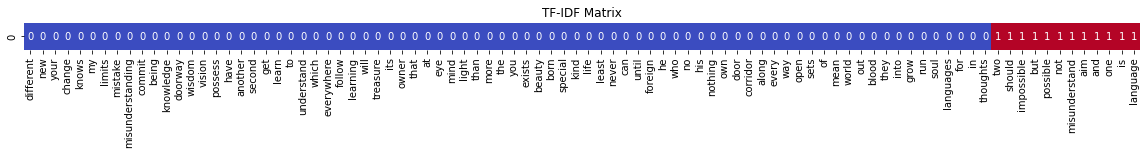

In [9]:
dfMaskStopwords = dfAvgWeights < 0.25    # mask of important words
PlotDTM(dfMaskStopwords.T, LnSize=[20, 0.5])
type(dfMaskStopwords)

Retrieve the stopwords. If needed, you could feed it back to the TF-IDF vectorizer and filter out these words.

In [10]:
LsStops = list(dfMaskStopwords[dfMaskStopwords.values].index)  # a list of auto-defined stop words
print(LsStops)

['two', 'should', 'impossible', 'but', 'possible', 'not', 'misunderstand', 'aim', 'and', 'one', 'is', 'language']


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

Equipped with these concepts and tools, you will tackle a few related tasks.
    
As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

## Task 1

Construct a histogram of non-zero values in `dfTFIDF`. Recall that in the previous activity in the previous notebook our distribution of TF-IDF weights contained most values between .3 and .6.

1. How did the distribution change and why?

<b>Hint:</b> You can create a mask on non-zero values and then use the NumPy matrix derived from the DataFrame to retrieve all the masked values. If you wrap the results into a DataFrame again, then call <code>hist()</code> to create the distribution (refer to the **Plotting Vectors, Matrices, and Pandas DataFrames** tool for details on constructing a histogram).


In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
aNonZeroValues = dfTFIDF.values[(dfTFIDF > 0).values]
pd.DataFrame(aNonZeroValues).hist(figsize=[15,3]); </pre>
        
The distribution shifted to the lower values because each sentence now contributes all words (including stopwords) to the matrix. Since the document vectors (rows) are normalized, the weights are smaller across a larger number of words. So, the distribution shows smaller weights.    
    </details> 
</font>
<hr>

## Task 2

Now, use `TfidfVectorizer` with stopwords saved to the `LsStops` variable and lowercase turned on to create `tv1` TF-IDF matrix from quotes above. Verify that the stopwords were removed by comparing the number of words in the DTM before and after this task.

1. How many words were in the previous DTM, `dfTFIDF`?
1. How many stopwords are in LsStops?
1. How many words are in your DTM now?

<b>Hint:</b> See the code above and use it as an example.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
    
print('Stopwords:', len(LsStops))
print('Words in DTM Before: ', dfTFIDF.shape[1])

tv1 = TfidfVectorizer(stop_words=LsStops, lowercase=True)   # direct approach of building TF-IDF weights
smTFIDF1 = tv1.fit_transform(LsQuotes)
print('Words in DTM After:  ', smTFIDF1.shape[1])

</pre>

The number of words dropped from 90 to 78.
    </details> 
</font>

<hr>

## Task 3

Use `PlotDTM()` to plot the `dfTFIDF1` DataFrame created from `tv1` output. Compute the sparsity (i.e., fraction of non-zero values) of this matrix

1. Do you still see any stopwords that appear in "too many" quotes? If so, how can you remedy this?
1. Do you note any words that appear only once?

<b>Hint:</b> See code above and use it as an example.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
dfTFIDF1 = pd.DataFrame(smTFIDF1.toarray(), index=LsQuotes, columns=tv1.get_feature_names())
nFrac = 1 - (dfTFIDF1>0).sum().sum() / dfTFIDF1.shape[0] / dfTFIDF1.shape[1]
print(f'Sparsity is {nFrac:.3}') # format to 3 decimal points. See f-string docs
PlotDTM(dfTFIDF1)</pre>

1. Yes, some stopwords still appear. For example, the word "for" has weights of 0.26 and 0.29. We could increase the threshold from 0.25 to 0.3. However, the bigger problem here is that many words appear only in one quote and do not contribute to similarities among quotes, making each quote unique. We want to keep meaningful words that appear in a few sentences (not one and not all of them).
2. Yes, plenty of words appear only once.
    </details>
</font>
<hr>

## Task 4

Create a histogram of non-zero weights in `dfTFIDF1`. 

1. How is it different from the previous histogram?

<b>Hint:</b> See code above and use it as an example.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
aNonZeroValues1 = dfTFIDF1.values[(dfTFIDF1 > 0).values]
pd.DataFrame(aNonZeroValues1).hist(figsize=[15,3]);</pre>

The density shifted to the right. Also, most weights are now centered around 0.3 with lesser variability. 
    </details> 
</font>
<hr>

## Task 5

Improve your TF-IDF matrix by removing all the words that appear only once. You can do this by specifying the `min_df` parameter of `TfidfVectorizer` to be 2, which requires words to appear in at least two sentences. Create a new TF-IDF called `tv2`, fit and transform it on quotes, and note the number of remaining words (columns). You can use `stop_words_` methods to view all words that dropped out due to this filter.

<b>Hint:</b> See code above and use it as an example.

In [ ]:
# check solution here



<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
tv2 = TfidfVectorizer(stop_words=LsStops, lowercase=True, min_df=2)   # direct approach of building TF-IDF weights
smTFIDF2 = tv2.fit_transform(LsQuotes)
print('Removed words:', tv2.stop_words_)
smTFIDF2
    </pre>
    </details> 
</font>

<hr>

## Task 6

Use `PlotDTM()` to plot `dfTFIDF2` created from the TF-IDF matrix in the previous task. Compute the sparsity fraction of this matrix.

1. Do you observe any words that appear only once?
1. Do you observe any problems with the document vectors? 
    1. If so, how can this be corrected?
    
<b>Hint:</b> See code above and use it as an example.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
dfTFIDF2 = pd.DataFrame(smTFIDF2.toarray(), index=LsQuotes, columns=tv2.get_feature_names())
print(f'Sparsity is {1 - (dfTFIDF2>0).sum().sum() / dfTFIDF2.shape[0] / dfTFIDF2.shape[1]:.3}')
PlotDTM(dfTFIDF2, LnSize=[10,5])</pre>

1. There are no words appearing only once. The table has far fewer columns and sparsity dropped from 90%+ to 80%.
2. One problem is that there are quotes that are defined by only one word, which is why those words have weight 1. For example, notice that the quote "A mistake is to commit a misunderstanding" is defined by the word "to," which does not have a specific semantic meaning that is important to us. One way to fix it is to standardize words further. For example, we could consider "misunderstanding" and "misunderstand" to be the same and perhaps even replace them with "understand."</details>
</font>
<hr/>

## Task 7

Evaluate a histogram of non-zero weights in `dfTFIDF2`. 

1. How is it different from the previous?

<b>Hint:</b> See code above and use it as an example.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
aNonZeroValues2 = dfTFIDF2.values[(dfTFIDF2 > 0).values]
pd.DataFrame(aNonZeroValues2).hist(figsize=[15,3]);</pre>

The distribution shifted to the right even more, since we do not have any weights below 0.3 anymore. Most weights are larger since we force document vectors to be unit vectors (each remaining word's contribution to unit length is higher).</details>
</font>
<hr>

## Task 8

Confirm that `dfTFIDF2` still has document vectors of unit length, but not the word vectors (i.e., columns).

<b>Hint:</b> See code above and use it as an example. 

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
print('Word vectors are not normalized to unit length: ', dfTFIDF2['at'] @ dfTFIDF2['at'])
print('Document vectors are normalized to unit length:', dfTFIDF2.iloc[0,:] @ dfTFIDF2.iloc[0,:])
    </pre>
    </details> 
</font>
<hr>